## Analyze A/B Test Results

## Table of Contents
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [2]:
#import pandas, numby, random and matplotlib
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

random.seed(42)

In [3]:
#read CSV file
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [4]:
# the number of rows & columns, 294478 rows and 5 cloumns
df.shape

(294478, 5)

The number of unique users in the dataset.

In [5]:
#the number of unique users
df['user_id'].nunique()

290584

The proportion of users converted.

In [6]:
# uses mean() to find the proportion of users converted
df.converted.mean()

0.11965919355605512

The number of times the `new_page` and `treatment` don't line up.

In [7]:
# use query to find out the number of times the new_page and treatment don't line up
treatment_old = df.query('group == "treatment" and landing_page == "old_page"').nunique()
control_new = df.query('group == "control" and landing_page == "new_page"').nunique()
treatment_old, control_new, treatment_old + control_new
df[((df['group'] == 'treatment') == (df['landing_page'] == 'new_page'))== False].shape[0]

3893

In [8]:
# check for any missing data in this dataset - no missing data since we had the same number of value for each column
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page. 

In [9]:
# creat new dataset stored in new dataframe df2
df2 = df[((df['group'] == 'treatment') == (df['landing_page'] == 'new_page'))]
df2.shape[0]

290585

In [10]:
# Check for the correct rows is removed 
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

The number of unique **user_id**s are in **df2**

In [11]:
# the number of unique users in df2
df2['user_id'].nunique()

290584

In [12]:
# check for any duplicated rows - there's 1 duplicated row
sum(df2['user_id'].duplicated())

1

In [13]:
#find the information of the duplicated row
ids = df2["user_id"]
df2[ids.isin(ids[ids.duplicated()])].sort_values("user_id")

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [14]:
#remove the duplicated row
df2.drop([2893], inplace=True)
df2.shape[0]

C:\Users\haya3\anaconda3\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


290584

In [15]:
#check again to ensure the duplicated row was removed 
sum(df2['user_id'].duplicated())

0

Probability of an individual converting regardless of the page they receive

In [16]:
#uses converted column to check for the probability of all users converted
df2['converted'].mean()

0.11959708724499628

Given that an individual was in the `control` group, what is the probability they converted?

In [17]:
#uses group column to check of the probability of converted users in control group
df2.query('group == "control"')['converted'].mean()

0.1203863045004612

Given that an individual was in the `treatment` group, what is the probability they converted?

In [18]:
#uses group column to check of the probability of converted users in treatment group
df2.query('group == "treatment"')['converted'].mean()

0.11880806551510564

What is the probability that an individual received the new page?

In [19]:
#uses landing_page column to check of the probability that an individual received the new page
df2.query("landing_page == 'new_page'").count()[0]/df2.shape[0]

0.5000619442226688

Consider our results, we will find out below whether we think there is sufficient evidence to say that the new treatment page leads to more conversions.

**Overall conversions rate:** 11.96%                                                                                               
**Control group - old page conversions rate:** 12.04%                                                                               
**Treatment group - new page conversions rate:** 11.88 %                                                                           
                                                                                                                               
Both groups received the pages equally, however the treatment group showed a decrease in conversions rate by 08% while the control group increased by 08%, even with this  small difference the results shows that the old page is more effective than the new page.                                                                                                                       
So, there's no proof that the new page is better than the old based on the conversion rate only.                               

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, we could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do we stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do we run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


For now, consider we need to make the decision just based on all the data provided.  If we want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be? 
We can state our hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

**Null hypothesis**: The new page is worse or the same as the old page.                                                                     
**$p_{new}$** - **$p_{old}$**  <= 0                                                                                                             
**Alternative hypothesis**: The new page is better than the old page.                                                                                                                                                                      
**$p_{new}$** - **$p_{old}$**  > 0                                                                                                       

The **convert rate** for $p_{new}$ under the null

In [20]:
#under the null hypothesis the convertion rate 11.96%
p_new = df2.converted.mean()
p_new

0.11959708724499628

The **convert rate** for $p_{old}$ under the null <br><br>

In [21]:
#under the null hypothesis the convertion rate 11.96%
p_old = df2.converted.mean()
p_old

0.11959708724499628

$n_{new}$

In [22]:
#the number of individuals who converted to new page is 145310
n_new = df2.query("landing_page == 'new_page'")['converted'].count()
n_new

145310

$n_{old}$

In [23]:
#the number of individuals who converted to new page is 145274
n_old = df2.query("landing_page == 'old_page'")['converted'].count()
n_old

145274

Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [24]:
#uses np.random.binomial to Simulate n_new transactions with a convert rate of p_new under the null hypothesis
new_page_converted = np.random.binomial(1, p_new, n_new)
new_page_converted.mean()

0.11992292340513386

Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [25]:
#uses np.random.binomial to Simulate n_old transactions with a convert rate of p_old under the null hypothesis
old_page_converted = np.random.binomial(1, p_old, n_old)
old_page_converted.mean()

0.1202210994396795

Find $p_{new}$ - $p_{old}$ 

In [26]:
#find the difference in the observed simulation
simulation_diff = new_page_converted.mean() - old_page_converted.mean()
print('The difference in the observed simulation: {}'.format(simulation_diff.mean()))

The difference in the observed simulation: -0.00029817603454564134


In [27]:
#uses np.random.binomial to Simulate 10,000  p_new - p_old values
new_converted_simulation = np.random.binomial(n_new, p_new, 10000)/n_new
old_converted_simulation = np.random.binomial(n_old, p_old, 10000)/n_old
p_diffs = new_converted_simulation - old_converted_simulation
p_diffs = np.array(p_diffs)
old_converted_simulation.mean(), new_converted_simulation.mean(), p_diffs.mean()

(0.119612645070694, 0.11960522331566995, -7.421755024051774e-06)

Plot a histogram of the **p_diffs**. 

In [28]:
#find the actual difference for each group
control_convert_actual = df2.query('group == "control"')['converted'].mean()
treatment_convert_actual = df2.query('group == "treatment"')['converted'].mean()
observed_diff = treatment_convert_actual - control_convert_actual

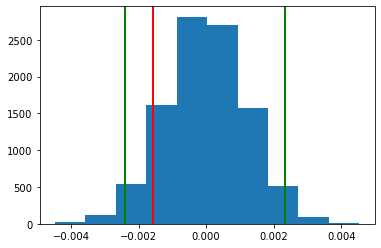

In [29]:
# view the confidence interval
p_diffs = np.array(p_diffs)
low, upper = np.percentile(p_diffs, 2.5), np.percentile(p_diffs, 97.5)
low, upper
plt.hist(p_diffs);
plt.axvline(x=low, color='g', linewidth=2);
plt.axvline(x=upper, color='g', linewidth=2);
plt.axvline(observed_diff, color='r', linewidth=2);

Based on the Central Limit Theorem, with a large enough sample size the sample mean follows a normal distribution as expected. 
Also, looking at the 97% Confidence Interval, most data points fall within this area suggesting that the null hypothesis value generated this statistic.

Proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**

In [30]:
#find proportion of values greater than observed_diff since alternative hypothesis > null hypothesis
print("The actual observed difference is: {}".format(observed_diff))
print("The proportion of p_diffs greater than observed (p-value): {}".format((p_diffs > observed_diff).mean()))

The actual observed difference is: -0.0015782389853555567
The proportion of p_diffs greater than observed (p-value): 0.9068


Since the alternative hypothesis is **p_new > p_old**, the probability that our observed statistic comes from this distribution is the shading from the observed statistic the red line to the right, and this is more than half of the distribution suggesting that our observed statistic does fall within right tail and supporting the null hypothesis that is: the old page converts better or equal than the new page.
                                                                                                                              
                                 
The p-value is the probability of observing our statistic or more extreme values in favor of the alternative hypothesis which is greater in this case, if the null hypothesis is true.                                                                       
While small p-value  means it is unlikely the we will observe our statistic from the null hypothesis, and more likely it came from the alternative hypothesis.                                                                                                                                                                                                                               
                                                                                                                               
**P-value**                                                                                                                     
**Type I error:** Deciding the new page is better, but really the old page is better.                                           
**Type II error:** Deciding the old page is better, but really the new page is better.                                         
**Type I error threshold is :** 0.05                                                                                           
**If p-value <= 0.05:** reject the null hypothesis.                                                                            
**If p-value > 0.05 :** fail to reject the null hypothesis.                                                                    
Since the p-value is **0.9** greater than the type I error threshold **0.05**, then trere's no reasonable evidence that the new page is better than the old page, so we fail to reject the null hypothesis.                                                                                         

In [31]:
import statsmodels.api as sm

convert_old = df2.query("landing_page == 'old_page' and converted == 1").shape[0]
convert_new = df2.query("landing_page == 'new_page' and converted == 1").shape[0]
n_old = df2.query("landing_page == 'old_page'").shape[0]
n_new = df2.query("landing_page == 'old_page'").shape[0]

Now use `stats.proportions_ztest` to compute your test statistic and p-value. 

In [32]:
#find the p_diffs mean(), std() and var() 
p_diffs.mean(), p_diffs.std(), p_diffs.var()

(-7.421755024051774e-06, 0.0011971003426360996, 1.4330492303394668e-06)

In [33]:
#find the z_score 
z_score, p_value = sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new], value=None, alternative='smaller', prop_var=False)
z_score, p_value

(1.2863207858559254, 0.9008344344112337)

The default parameter for proportions_ztest assumes:                                                                           
**Null hypothesis:** p_new - p_old = 0                                                                                         
(no difference between two proportions)                                                                                         
**Alternative hypothesis :** p_new - p_old != 0                                                                                 
 (a statistical difference between two proportions)                                                                             
                                                                                                                               
**P-value** is a probability that we have falsely rejected the null hypothesis, while **Z-score** measures standard deviation. 
                                                                                                                               
This is another test of statistical significance that helps on decide whether or not to reject the null hypothesis.             
In this case, since the standard deviation here is small but the p-value is large, that doesn't make a difference.             
The large p-value suggests that : converstions of the old page are statistically better than the new page.

<a id='regression'></a>
### Part III - A regression approach

In this final part, we will see that the result we acheived in the previous A/B test can also be acheived by performing regression.<br><br>

Since each row is either a conversion or no conversion, what type of regression should we be performing in this case?!

**Regression Types/ Models**                                                                                                   
**Simple Linear:**                                                                                                              compare 2 quantitative variables - use one explanatory variable (x) to predict a response variable (y).                         
**Multiple Linear :**                                                                                                     compare multiple explanatory variables (X) to predict a response variable (y), predicted response any value between negative and positive infinity.                                                                                                         
**Logistic:**                                                                                                              predict categorical data with only 2 outcomes (predicts a probability between 0 and 1)                                         
Logistic Regression should be used since we want to predict one of two  possible outcomes: whether a user will convert or not depending on the page (old or new).

The goal is to use **statsmodels** to fit the regression model to see if there is a significant difference in conversion based on which page a customer receives.  However, we first need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [34]:
#create new column called intercept and new column for get_dummies() of pages
df2['intercept'] = 1
df2[['new_page', 'old_page']] = pd.get_dummies(df2['landing_page'])
df2[['control', 'ab_page']] = pd.get_dummies(df2['group'])
#view head to ensure the new columns applied 
df2.head()

<ipython-input-34-008024aeb792>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['intercept'] = 1
C:\Users\haya3\anaconda3\lib\site-packages\pandas\core\frame.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


,user_id,timestamp,group,landing_page,converted,intercept,new_page,old_page,control,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,1,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,1,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,0,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,0,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,1,1,0


In [35]:
#use drop() to remove any unnecessary columns
df2.drop(['new_page', 'control' ], axis=1, inplace=True)
df2.head()

C:\Users\haya3\anaconda3\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,user_id,timestamp,group,landing_page,converted,intercept,old_page,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,1,0


c. Use **statsmodels** to import regression model.  Instantiate the model, and fit the model using the two columns we created to predict whether or not an individual converts.

In [36]:
from scipy import stats

stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)

In [37]:
#use logistic model
logit_reg = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
results = logit_reg.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Sun, 20 Jun 2021   Pseudo R-squ.:               8.077e-06
Time:                        09:04:52   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

In [38]:
#we take the exponentiate the coefficients
1/np.exp(-0.0150)

1.015113064615719

The new page is 1.015 times less likely to convert a users.                                                                     
We used dummy variables to add categorical data to the matrix, when using dummies, we must remove one of the categories(since it is inferred by the remaining category - categories), and the intercept becomes the baseline removed category.               
Since we removed 'control' and kept 'ab_page', that means  it becomes our baseline:                                             
intercept = control group = old page.                                                                                           
baseline : conversions are -1.9888.                                                                                             
p-value for old_page: 0                                                                                                         
statistically significant it's useful in predicting a response.                                                                 
The slope: less conversions than old page, negative slope.                                                                     
ab_page = treatment group = new page: -0.015 from intercept.                                                                   
p-value for ab_page : 0.190                                                                                                     
not statistically significant it's not useful in predicting a response.

In regression, the p-value is for testing if a parameter for intercept or slope equal zero **(Null hypothesis)** or does not equal zero **(alternative hypothesis)**.                                                                                                 
                                                                                                                               
**Null parameter  = 0**                                                                                                         
**Alternative parameter  != 0**                                                                                                 
Smaller p-values (< 0.05) suggest that specific variable is statistically significant in relating to the response variable, the slope associated with (x) in relating to (y) is non-zero.                                                                       
p-value for old page (x): 0.0                                                                                                   
Statistically significant in relating to the response variable, the slope associated with (x) in relating to (y) is non-zero.   
p-value for new ab_page (x): 0.190                                                                                               
Not statistically significant in relating to the response variable, the slope associated with (x) in relating to (y) is zero.   
These p-values differ from previous p-value, because in the A/B test our null hypothesis consist that the old page is better than or equal to the new page (one-tailed).                                                                                             
However, regression is a two-tailed test, therefore p-values have a different meaning regarding to slope.

**one of the disadvantages of adding additional terms into a regression model is:** collinearity.                                   
We want to have a linear relationship between our predictor (X)with our response (y) variable, but when we add more predictors they might end up correlating with each other.                                                                                 
                                                                                                                               
Also, when (X) variables don't have a linear relationship, we could consider higher order terms, such as : interactions, quadratics, and cubics.                                                                                                         
like: if the slopes of the  x variables are not parallel, this indicates that an interaction between those variables is present.                                                                                                                       
In this case, we can create a new column that multiplies these two values and review this additional interaction with the predictor (y) variable.                                                                                                         

Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. We will need to read in the **countries.csv** dataset and merge together our datasets on the approporiate rows.  

Does it appear that country had an impact on conversion? 

In [39]:
#load countries CSV file
countries_df = pd.read_csv('./countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')

In [40]:
#the number of unique countries in this dstaset
df_new['country'].unique()

array(['UK', 'US', 'CA'], dtype=object)

In [41]:
### Create the necessary dummy variables
df_new[['CA', 'UK', 'US']] = pd.get_dummies(df_new['country'])
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,old_page,ab_page,CA,UK,US
user_id,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,1,0,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,0,1,0,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,0,1,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,1,0,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,0,1,0,1,0


In [42]:
#use logistic model# drop US 
logit_reg = sm.Logit(df_new['converted'], df_new[['intercept', 'CA', 'UK']])
results = logit_reg.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Sun, 20 Jun 2021   Pseudo R-squ.:               1.521e-05
Time:                        09:05:04   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1984
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9967      0.007   -292.314      0.000      -2.010      -1.983
CA            -0.0408      0.027     -1.518      0.129      -0.093       0.012
UK             0.0099      0.013      0.746      0.456      -0.016       0.036
==============================================================================
"""

In [43]:
#we take the exponentiate the coefficients
1/np.exp(-0.0408), np.exp(0.0099)

(1.0416437559600236, 1.0099491671175422)

Compared to **US** overall conversions:                                                                                         
**CA** is 1.0416 times less likely to convert.                                                                                  
**UK** is 1.0099 times more likely to convert.   

Though we have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  

In [44]:
### Fit Your Linear Model And Obtain the Results
df_new['UK_new_page'] = df_new['UK']*df_new['ab_page']
df_new['US_new_page'] = df_new['US']*df_new['ab_page']
df_new['CA_new_page'] = df_new['CA']*df_new['ab_page']
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,old_page,ab_page,CA,UK,US,UK_new_page,US_new_page,CA_new_page
user_id,,,,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,1,0,0,1,0,0,0,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,0,1,0,0,1,0,1,0
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,0,1,0,1,0,1,0,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,1,0,0,1,0,0,0,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,0,1,0,1,0,1,0,0


In [51]:
#use logistic model
logit_reg = sm.Logit(df_new['converted'], df_new[['intercept','CA','UK','CA_new_page', 'UK_new_page']])
results = logit_reg.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290579
Method:                           MLE   Df Model:                            4
Date:                Sun, 20 Jun 2021   Pseudo R-squ.:               2.417e-05
Time:                        09:44:18   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.2729
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
intercept      -1.9967      0.007   -292.314      0.000      -2.010      -1.983
CA             -0.0073      0.037     -0.196      0.844      -0.080       0.065
UK              0.0045      0.018      0.257      0.797      -0.030       0.039
CA_new_page    -0.0674      0.052     -1.297      0.195      -0.169       0.034
UK_new_page     0.0108      0.023      0.475      0.635      -0.034       0.056
===============================================================================
"""

In [47]:
#we take the exponentiate the coefficients
1/np.exp(-0.0073), np.exp(0.0045)

(1.0073267099546657, 1.0045101402046013)

In [48]:
#we take the exponentiate the coefficients
1/np.exp(-0.0674), np.exp(0.0108)

(1.0697232819209153, 1.010858530520097)

   
For the treatment group those that received the new page and compared to **US** conversions:                                       
**CA** is 1.073 times less likely to convert to new page.                                                                                       
**UK** is 1.011 times more likely to convert to new page.                                                                                       
compared to **US, CA** the overall new page conversions is lower, and to **UK** overall new page conversions is higher, perhaps the **UK** has drawn to change while **CA** hasn't, but these observed differences are quite small.

<a id='conclusions'></a>
## Conclusions
                                                                                                                               
     
- It seems the old page has a higher convertion rate than the new page, In other words, the old page is more effactive than the new page, since :                                                                                                           
**Overall conversions:** 11.96%                                                                                                     
**Control (old page) conversions:** 12.04% (.08% increase)                                                                         
**Treatment (new page) conversions:** 11.88% (.08% decrease)                                                                       
known that each group received the the pages equally, however the treatment group showed a decrease in conversions rate by **08%** while the control group increased by **08%**.                                                                                                                                                                                                          
- According to the AB test results that the new page is less or equal to the old page **(Null hypothesis)** which is true after get the test  results, while the **(alternative hypothesis)** is the new page is better the old page which is what we fail to prove, since there's not suffient evidence support this hypothesis.                                                                                                                                                                                                                                                                                                                   
- The country has effact on the convertion rate between these country, while the new page convertion rate in **CA** is low, the **UK** new page convertion rate is high.                                                                                   